## Regridding the Belgian population density
Functions are developed by Charles Simpson (UCL)

### 0.1 Loading Packages

In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point, get_shapefile_mask
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean, calc_metrics_dt, calc_metrics_da,_add_ranks_metrics, root_mean_square_error, diurnal_cycle
from valenspy.diagnostic.visualizations import plot_time_series, plot_map, plot_metric_ranking, plot_diurnal_cycle

from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import xoak
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import shapely
from scipy.spatial import Voronoi

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)

In [22]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Code modified from StackOverflow.
    https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def get_vor(ds, lat_name, lon_name, proj_x_name, proj_y_name, grid_crs, varname, time_name):
    """
    Get finite Voronoi polygons for a non-rectlinear grid from an xarray d[input_grid["varname"]]et.
    """
    # Get coordinates
    ds = ds.sortby([proj_x_name, proj_y_name])
    lat_, lon_ = ds[lat_name].values.ravel(), ds[lon_name].values.ravel()
    x, y = np.meshgrid(ds[proj_x_name].values, ds[proj_y_name].values)
    points = np.column_stack((lon_, lat_))
    # Compute Voronoi tesselation.
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    # Implicitly the regions are in the same order as the points contained in vor.point_region.
    boxes = [
        (
            shapely.geometry.Polygon(vertices[g])
            if -1 not in g
            else shapely.geometry.Point(0, 0)
        )
        for g in regions
    ]
    boxes = [
        b.intersection(
            shapely.geometry.box(lon_.min(), lat_.min(), lon_.max(), lat_.max())
        )
        for b in boxes
    ]
    # Turn it into a GeoDataFrame
    gdf_vor = gpd.GeoDataFrame(
        geometry=boxes,
        crs=grid_crs,
    )
    # Join it back to the points to make sure the x and y coordinates are correct.
    gdf_points = gpd.GeoDataFrame(
        {
            proj_x_name: x.ravel(),
            proj_y_name: y.ravel(),
            lat_name: lat_.ravel(),
            lon_name: lon_.ravel(),
        },
        geometry=gpd.points_from_xy(lon_, lat_),
        crs=grid_crs,
    )
    gdf_vor = gdf_vor.sjoin(gdf_points)
    gdf_vor = gdf_vor.set_index([proj_y_name, proj_x_name])
    return gdf_vor


def get_vor_rectilinear(ds, lat_name, lon_name, grid_crs, varname):
    """
    Construct a rectilinear grid from an xarray object.
    """
    # Get coordinates
    lat_, lon_ = ds[lat_name].values, ds[lon_name].values
    width, height = (lon_[1] - lon_[0]) / 2, (lat_[1] - lat_[0]) / 2
    lat_, lon_ = np.meshgrid(lat_, lon_)
    lat_, lon_ = lat_.ravel(), lon_.ravel()
    # In this case, we already know exactly what the Voronoi tesselation is, as
    # the grid is rectilinear. This saves a bit of compute time.
    boxes = [
        shapely.geometry.box(x1 - width, y1 - height, x1 + width, y1 + height)
        for x1, y1 in zip(lon_, lat_)
    ]
    gdf_vor = gpd.GeoDataFrame(
        {lat_name: lat_, lon_name: lon_},
        geometry=boxes,
        crs=grid_crs,
    )
    gdf_vor = gdf_vor.set_index([lat_name, lon_name])
    return gdf_vor


### 0.2 Identifying original climate model

In [23]:
orig_grid = "CCLM"

### 0.3 Quick visualisation of population density

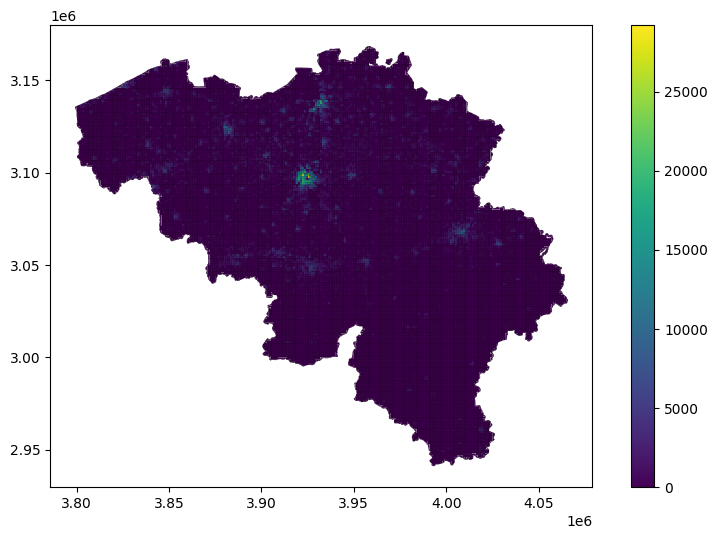

In [24]:
ucl_dir = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/" 
file = ucl_dir + "geo_files/" + "TF_POPULATION_GRID_3035_20200101.shp"
gdf = gpd.read_file(file)

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(column="ms_pop", cmap="viridis", legend=True, ax=ax, edgecolor="black", linewidth=0.1)
attribute = "ms_pop"


## 1. Loading all required data

### 1.1 Creating netcdf from tiff for population

NetCDF file saved as /dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/geo_files/TF_POPULATION_GRID_3035_20200101_FS.nc


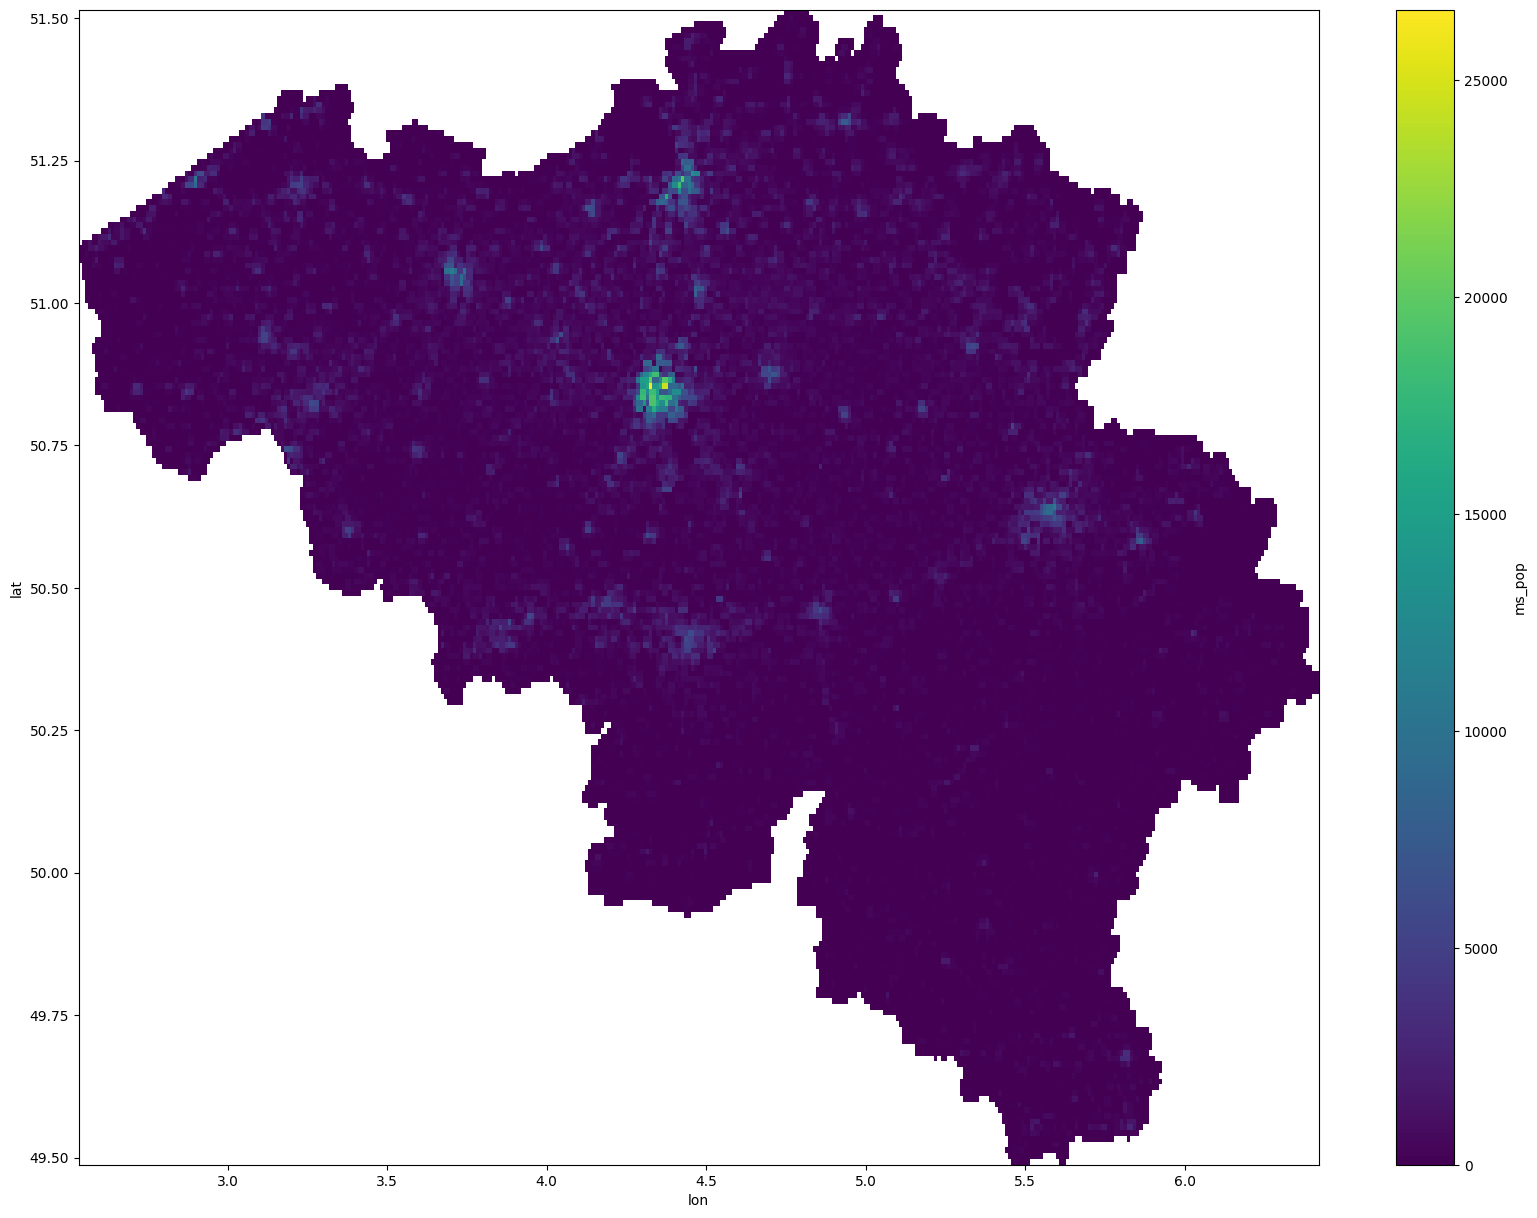

In [25]:
netcdf_path = ucl_dir + "geo_files/" + "TF_POPULATION_GRID_3035_20200101_FS.nc"
if not Path(netcdf_path).exists():
    # Load the shapefile
    shapefile_path = "TF_POPULATION_GRID_3035_20200101.shp"
    gdf = gpd.read_file(file)

    # Ensure CRS is in lat/lon (EPSG:4326)
    if gdf.crs is None or gdf.crs.to_string() != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  

    # Define the attribute column to rasterize
    attribute = "ms_pop"  # Replace with your column name

    # Define resolution (grid cell size in degrees) 
    resolution = 0.01  # Approx. 1 km 

    # Get bounds of the shapefile
    minx, miny, maxx, maxy = gdf.total_bounds

    # Define grid shape
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)

    # Create an empty raster array (filled with NaNs)
    raster = np.full((height, width), np.nan, dtype=np.float32)

    # Rasterize the polygons using population values
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[attribute]))

    rasterized = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=from_bounds(minx, miny, maxx, maxy, width, height),
        fill=np.nan,  # Fill empty cells with NaN
        all_touched=True,  # Capture all pixels touched by the polygon
        dtype="float32"
    )

    # Generate lat/lon coordinates
    lon = np.linspace(minx, maxx, width)
    lat = np.linspace(maxy, miny, height)  # Flip lat to match NetCDF convention

    # Create an xarray Dataset
    ds = xr.Dataset(
        {attribute: (["lat", "lon"], rasterized)},
        coords={"lat": lat, "lon": lon},
    )

    # # Save to NetCDF
    netcdf_path = ucl_dir + "geo_files/" + "TF_POPULATION_GRID_3035_20200101_FS.nc"
    ds.to_netcdf(netcdf_path)

print(f"NetCDF file saved as {netcdf_path}")
ds["ms_pop"].plot(figsize=(20,15))

### Regridding based on Charles' script

In [26]:
# Specify the file paths
WRF_grid = Path(ucl_dir + "WRF_output/" + "WRF_run_urban_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190720-20190729.nc")
CCLM_grid = Path("/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/hourly/" + "T_2M_hourly_20190720.nc")
UrbClim_grid = Path(ucl_dir + "UrbClim_T2M_hourly_baseline_20190713-20190728.nc")
path_pop = Path(netcdf_path)


In [27]:
# Specify things to do with the destination grid file.
if orig_grid == "CCLM":
    path_grid = CCLM_grid
    input_grid = dict(
        varname="T_2M",
        time_name = "time",
        lat_name="lat",
        lon_name="lon",
        proj_x_name="rlon",
        proj_y_name="rlat",
        grid_crs="EPSG:4326",  # Check this! I think it's right
    )
elif orig_grid == "WRF":
    path_grid = WRF_grid
    input_grid = dict(
        varname="T2",
        time_name = "XTIME",
        lat_name="XLAT",
        lon_name="XLONG",
        proj_x_name="south_north",
        proj_y_name="west_east",
        grid_crs="EPSG:4326",  # Check this! I think it's right
    )
elif orig_grid == "UrbClim":
    path_grid = UrbClim_grid
    input_grid = dict(
        varname="T2M",
        time_name = "time",
        lat_name="x",
        lon_name="y",
        proj_x_name="x",
        proj_y_name="y",
        grid_crs="EPSG:4326",  # Check this! I think it's right
    )

output_path = path_pop.parent / f"{path_pop.stem}_regrid2{orig_grid}.nc"

input_pop = dict(
    varname="ms_pop",
    lat_name="lat",
    lon_name="lon",
    grid_crs="EPSG:4326",  # Check this! I think it's right
)

In [28]:
# %%
# Get the gridding of the air temperature.
ds_grid = xr.open_dataset(path_grid).isel({input_grid["time_name"]: 1})
if orig_grid == "WRF":
    ds_grid = ds_grid.assign_coords({"lat":ds_grid.XLAT})
    ds_grid = ds_grid.assign_coords({"lon":ds_grid.XLONG})
    #ds_grid = ds_grid.xoak.set_index(['XLAT', 'XLONG'], 'sklearn_geo_balltree') ## Added test wrf
gdf_grid = get_vor(ds_grid, **input_grid)

In [29]:
ds_grid

<xarray.Dataset> Size: 1MB
Dimensions:       (bnds: 2, rlat: 320, rlon: 260)
Coordinates:
    time          datetime64[ns] 8B 2019-07-20T01:00:00
    lon           (rlat, rlon) float32 333kB ...
    lat           (rlat, rlon) float32 333kB ...
  * rlon          (rlon) float32 1kB -3.263 -3.237 -3.213 ... 3.162 3.188 3.213
  * rlat          (rlat) float32 1kB -4.012 -3.987 -3.963 ... 3.912 3.938 3.963
    height_2m     float32 4B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (bnds) datetime64[ns] 16B ...
    rotated_pole  |S1 1B ...
    T_2M          (rlat, rlon) float32 333kB ...
Attributes: (12/14)
    CDI:             Climate Data Interface version 2.3.0 (https://mpimet.mpg...
    Conventions:     CF-1.4
    source:          cosmo6.00_clm2, int2lm3.0_clm1
    institution:     KU Leuven, Leuven, BELGIUM
    title:           BE_28 Ecoclimap Nukleus Transient
    project_id:      CORDEXbe2
    ...              ...
    conventionsURL:  http://www.cfconventions.org/
    contact:         FIEN SERRAS (fien.serras@kuleuven.be)
    references:      http://ees.kuleuven.be/rcs/
    creation_date:   2024-12-03 22:52:20
    history:         Thu Jan 02 17:56:16 2025: cdo mergetime hourly/temp/T_2M...
    CDO:             Climate Data Operators version 2.3.0 (https://mpimet.mpg...

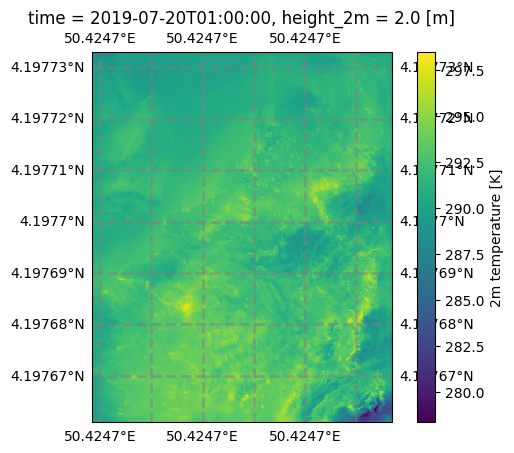

In [30]:
# %%
# Visually check the input
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
ax = plt.axes(
    projection=ccrs.Orthographic(
        central_longitude=ds_grid[input_grid["lat_name"]].mean().item(),
        central_latitude=ds_grid[input_grid["lon_name"]].mean().item(),
    )
)
ds_grid[input_grid["varname"]].plot(ax=ax)
ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="gray",
    alpha=0.5,
    linestyle="--",
)


<Axes: >

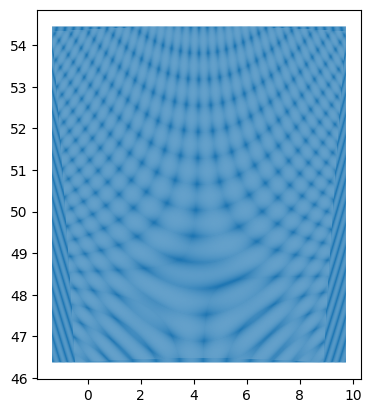

In [31]:
gdf_grid.join(
    ds_grid[input_grid["varname"]].to_dataframe()[input_grid["varname"]]
).plot()

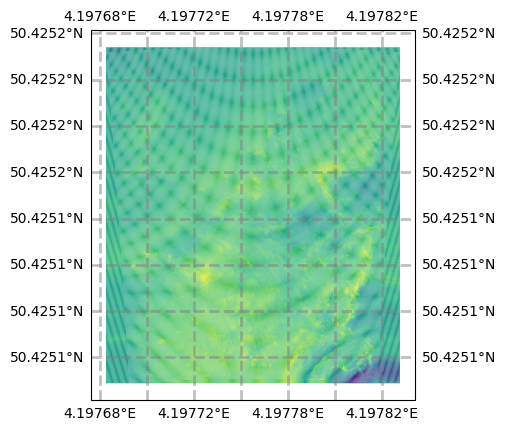

In [32]:
# %%
# Visually check the output
ax = plt.axes(
    projection=ccrs.Orthographic(
        central_longitude=ds_grid[input_grid["lon_name"]].mean().item(),
        central_latitude=ds_grid[input_grid["lat_name"]].mean().item(),
    )
)
gdf_grid.join(
    ds_grid[input_grid["varname"]].to_dataframe()[input_grid["varname"]]
).plot(input_grid["varname"], ax=ax, edgecolor="none")
ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="gray",
    alpha=0.5,
    linestyle="--",
)

<Axes: >

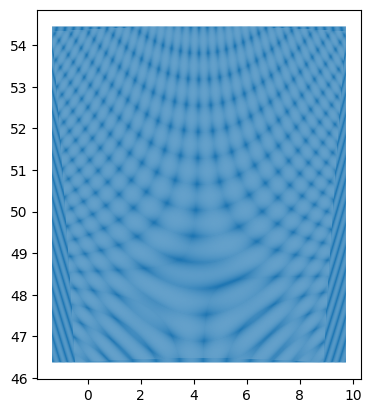

In [33]:
gdf_grid.plot()

/tmp/ipykernel_2789895/3381059393.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_pop = gdf_pop.assign(area_pop=gdf_pop.area)
/tmp/ipykernel_2789895/3381059393.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_grid = gdf_grid.assign(area_grid=gdf_grid.area)
/tmp/ipykernel_2789895/3381059393.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_join = gdf_join.assign(area_inter=gdf_join.area)
/tmp/ipykernel_2789895/3381059393.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of p

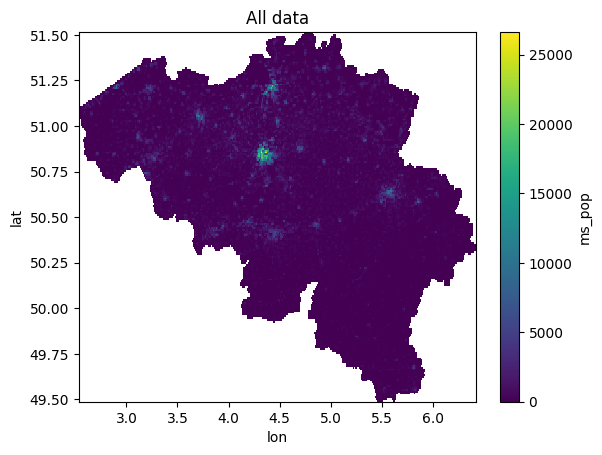

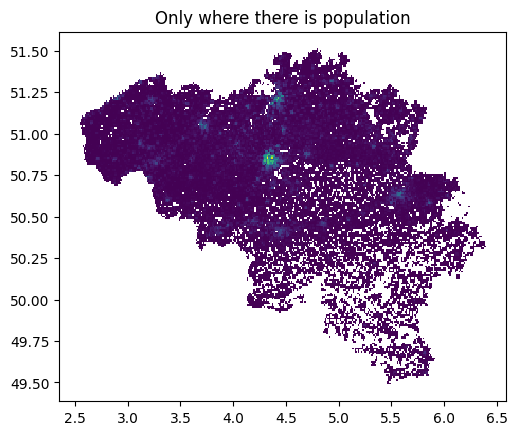

In [34]:
# %%
# Get the gridding of the population.
ds_pop = xr.open_dataset(path_pop)
gdf_pop = get_vor_rectilinear(ds_pop, **input_pop)
gdf_pop = gdf_pop.join(
    ds_pop.to_dataframe()[input_pop["varname"]]
)  # Assign the population to the new geodataframe.
# %%
# Check it visually.
ds_pop[input_pop["varname"]].plot()
plt.gca().set_title("All data")
gdf_pop[gdf_pop[input_pop["varname"]]>0].plot(input_pop["varname"], edgecolor="none")
plt.gca().set_title("Only where there is population")

# # %%
gdf_pop = gdf_pop.fillna(0)  # don't want NaN population
gdf_pop = gdf_pop.assign(area_pop=gdf_pop.area)
gdf_grid = gdf_grid.assign(area_grid=gdf_grid.area)

# # %%
# # Get a set of geometries that encodes the intersection of the two sets of
# # geometries. (This takes a few minutes)
gdf_join = gpd.overlay(
    gdf_pop, gdf_grid, "intersection"
)  # This automatically uses a spatial index, but will still take a while as there are a lot of geometries.
gdf_join = gdf_join.assign(area_inter=gdf_join.area)

# # %%
# # Now find the intersection between the two, and use area weighting to put the
# # population data into the gridding of the temperature data.
# #
# # index_right is the index of gdf_grid, which came in when the points were
# # spatially joined to the Voronoi polygons.
# #
# # (This takes a few minutes.)
df_result = gdf_join.groupby("index_right").apply(
    lambda _df: ((_df[input_pop["varname"]] / _df.area_pop) * _df.area_inter).sum()
)
# # %%
# # Assign the result to the grid.
gdf_grid = (
    gdf_grid.set_index("index_right")
    .assign(population=df_result)
    .set_index(gdf_grid.index)
)

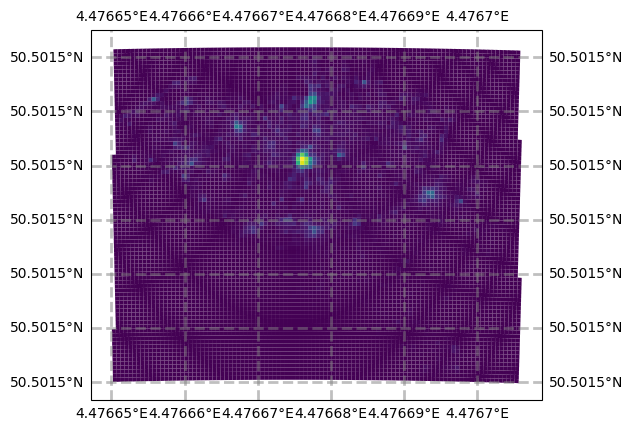

In [35]:
# # Visually check the ouput
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
ax = plt.axes(
    projection=ccrs.Orthographic(
        central_longitude=ds_pop.lon.mean().item(),
        central_latitude=ds_pop.lat.mean().item(),
    )
)
gdf_grid.plot("population", ax=ax)
ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="gray",
    alpha=0.5,
    linestyle="--",
)

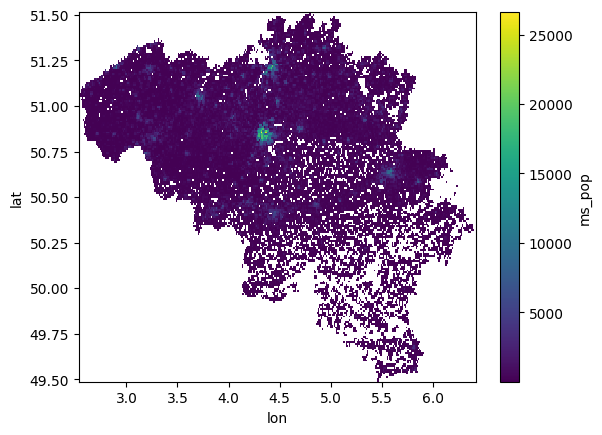

In [36]:
# %%
# Turn the result back into an xarray object.
ds_grid_pop = gdf_grid.to_xarray()[["population", input_grid["lat_name"], input_grid["lon_name"]]].astype("float32")

# %%
# Visually check that the result makes sense.
# Before
ds_pop[input_pop["varname"]].where(ds_pop[input_pop["varname"]] > 1).plot()


In [37]:
# if orig_grid == "WRF":
#     ds_grid_pop = ds_grid_pop.assign_coords({"lat":ds_grid_pop.XLAT})
#     ds_grid_pop = ds_grid_pop.assign_coords({"lon":ds_grid_pop.XLONG})
#     #s_grid_pop.xoak.set_index(['XLAT', 'XLONG'], 'sklearn_geo_balltree')
#ds_grid_pop
da_grid_pop = ds_grid_pop["population"]
da_grid_pop

<xarray.DataArray 'population' (rlat: 320, rlon: 260)> Size: 333kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * rlat     (rlat) float32 1kB -4.012 -3.987 -3.963 ... 3.912 3.938 3.963
  * rlon     (rlon) float32 1kB -3.263 -3.237 -3.213 ... 3.162 3.188 3.213

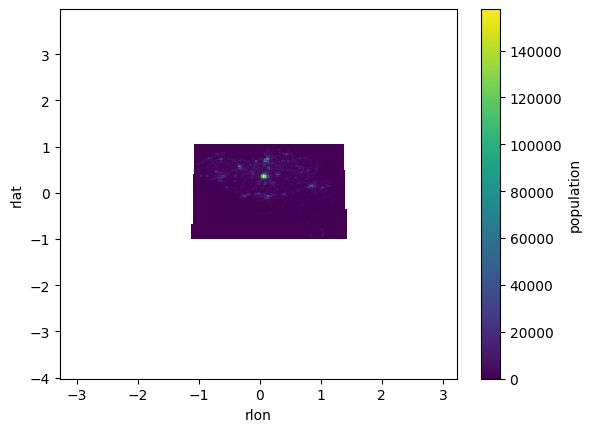

In [38]:
da_grid_pop = ds_grid_pop["population"]
da_grid_pop.plot()
#da_grid_pop.plot(x="lat", y="lon")

Checking conservation of population. Original population / new population = 1.0


PermissionError: [Errno 13] Permission denied: '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/geo_files/TF_POPULATION_GRID_3035_20200101_FS_regrid2CCLM.nc'

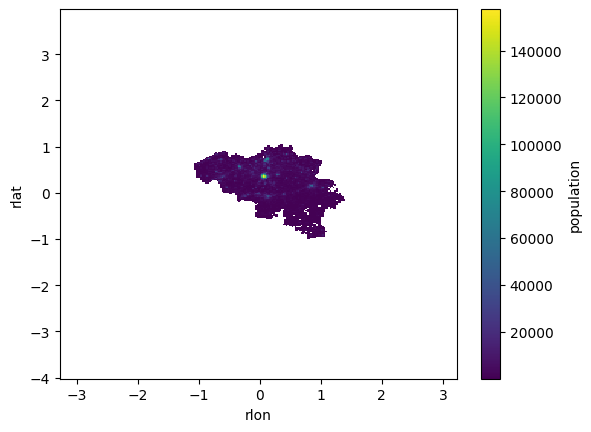

In [39]:
# After
ds_grid_pop.population.where(ds_grid_pop.population > 1).plot()

# Fewer grid cells have identically zero population, many have small values.

# %%
# Check that the total population is close to conserved.
print(
    "Checking conservation of population. Original population / new population =",
    ds_pop[input_pop["varname"]].sum().item() / ds_grid_pop.population.sum().item(),
)

# %%
ds_grid_pop[["population", input_grid["lat_name"], input_grid["lon_name"]]].to_netcdf(output_path)

# %%
output_path

In [40]:
# %%
# Check that it is possible to calculate a population weighted temperature
(ds_grid_pop.population * ds_grid[input_grid["varname"]]).sum() / (ds_grid_pop.population.sum())



<xarray.DataArray ()> Size: 4B
np.float32(293.05676)
Coordinates:
    time       datetime64[ns] 8B 2019-07-20T01:00:00
    height_2m  float32 4B ...